# Exploratory Data Analysis

## Data Preview

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Recommendation
from surprise.prediction_algorithms import knns, SVD
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy, Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
links_df = pd.read_csv('1-data/links.csv')
movies_df = pd.read_csv('1-data/movies.csv')
ratings_df = pd.read_csv('1-data/ratings.csv')
tags_df = pd.read_csv('1-data/tags.csv')

In [3]:
# Peek head of each df
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Merge datasets

At the moment, the data is imported from disparate tables / files. In this next step, let's focus on the user rating and movies dataframe and merge them into a single dataframe to set up for our recommendation system. For now we can set aside tags and links df.

Below are some noted observations about the MovieLens data.
- Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.
- Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
- Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.
- Genres are pipe separated
- Our links dataframe contains external information to IMDB and MovieDB information, but since we are focused on building a collaborative filter for the time bring, we do not require this information

In [7]:
movieRatings_df = pd.merge( movies_df, ratings_df, how='left', on='movieId' )

# Observe for any data loss during merge
print(f'movies_df shape {movies_df.shape}')
print(f'ratings_df shape {ratings_df.shape}')
print(f'movieRatings_df {movieRatings_df.shape}')

movies_df shape (9742, 3)
ratings_df shape (100836, 4)
movieRatings_df (100854, 6)


In [8]:
movieRatings_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


We see now that we have duplicate values between movieId, title and genres since there are multiple users ratings the same movie. 

In upcoming steps, we will aim to create a matrix of the user (m) and movieId (n) -- m x n and so we will not concern ourselves with the duplication we are seeing currently. 

Regarding the timestamp, we are not really concerned about the time in which the ratings were given and so we will drop this column.

In [9]:
# Drop timestamp column from movieRatings_df
movieRatings_df.drop(['timestamp','title','genres'],axis=1,inplace=True)

# Peek data
movieRatings_df.head()

,movieId,userId,rating
0,1,1.0,4.0
1,1,5.0,4.0
2,1,7.0,4.5
3,1,15.0,2.5
4,1,17.0,4.5


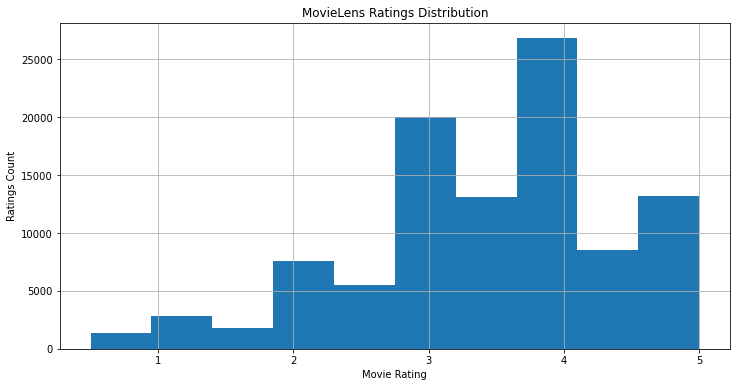

In [10]:
# Observe distribution of ratings
movieRatings_df.rating.hist(figsize=(12,6))
plt.title('MovieLens Ratings Distribution')
plt.ylabel('Ratings Count')
plt.xlabel('Movie Rating');

In [11]:
print(movieRatings_df.rating.unique())

[4.  4.5 2.5 3.5 3.  5.  0.5 2.  1.5 1.  nan]


# Training and test sets

For our recommendation system, we will use the collaborative filtering method to make predictions about the interest of a user by analyzing the preferences or ratings from many users on the aggregate level.

The range of ratings of movies is between 0.5 - 5. Our aim is to predict the rating, given a user and a movie. Since the ratings can take on ten discrete values we are able to model this as a regression problem.

In [12]:
movieRatings_df.dropna(inplace=True)

In [13]:
movieRatings_df.head()

,movieId,userId,rating
0,1,1.0,4.0
1,1,5.0,4.0
2,1,7.0,4.5
3,1,15.0,2.5
4,1,17.0,4.5


In [66]:
# Assign X and y movieRatings_df
X = movieRatings_df.copy()
y = movieRatings_df['userId']

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

# Collaborative Filtering
With our collaborative filter models, we will take a userId and a movieId and output a rating between 0.5 and 5.

# Collaborative Filtering Methods

Simple
- Mean
- Weighted Mean

Memory Based (Neighborhood Based)
Using different types of similarities (cosine, msd, pearson)
- Item-based Collaborative Filtering
- User-based Collaborative Filtering

Model Based (Simon Funk's SVD)

## Memory based CF Models

## Baseline model

We will define a baseline collaborative filter model which will return a rating of 3 regardless of userId or movieId. 

In [15]:
def baseline_model(userId, movieId):
    """
    Params: userId int; movieId int
    
    Return movie rating
    """
    return 3.0

In [16]:
def rmse_score(y_true, y_pred):
    """
    Params: y_true; array of true values
            y_pred; array of predicted values
    
    Return root mean square error to evaluate model
    """
    return np.sqrt( mean_squared_error(y_true,y_pred) )

In [17]:
# Construct list of user-move tuples from testing set
userMovie_pairs = zip(X_test['userId'],X_test['movieId'])

In [18]:
# Predict using baseline model
y_pred = np.array( [ baseline_model(user, movie) for (user,movie) in userMovie_pairs ] )

In [19]:
# Score baseline model
y_true = np.array(X_test['rating'])

baselineCF_score = rmse_score(y_true,y_pred)

print(f'Baseline Collaborative Filter RMSE Score: {baselineCF_score}')

Baseline Collaborative Filter RMSE Score: 1.1531234800163512


In [20]:
# Save baseline model to concat and compare with other model results
baselineModel_df = pd.DataFrame( {'test_rmse':[baselineCF_score],
                    'fit_time':[None],
                    'test_time':[None],
                    'model':['Baseline Model']} )

baselineModel_df

,test_rmse,fit_time,test_time,model
0,1.153123,None,None,Baseline Model


Our baseline collaborative model RMSE score is 1.15.

In subsequent models, we will aim to score an RMSE score below 1.15.

### Simple Mean Collaborative Filters

Here we will taking in the userId and movieId and output the mean rating for the movie by all users who have rated it. The rating of each user is assigned equal weight.

In the case that movies are available in the test set and not training set, we will default to assigning a rating of 3.0

### Build Matrix

In [21]:
# ratings_matrix = X_train.pivot_table(values='rating',index='userId',columns='movieId')
ratings_matrix = movieRatings_df.pivot_table(values='rating',index='userId',columns='movieId')

ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
def score(cf_model):
    
    # Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(X_test['userId'], X_test['movieId'])
    
    # Predict the rating for every user-movie tuple
    y_pred = np.array([cf_model(user, movie) for (user, movie) in id_pairs])
    
    # Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['rating'])
    
    # Return the final RMSE score
    return rmse_score(y_true, y_pred)

In [68]:
def cf_mean_model(userId, movieId):
    
    # Check if movie_id exists in ratings_matrix
    if movieId in ratings_matrix:
        # Compute the mean of all the ratings given to given movieId
        mean_rating = ratings_matrix[movieId].mean()
    
    else:
        # Default to a rating of 3.0 if no information
        mean_rating = 3.0
    
    return mean_rating

In [69]:
# Score cf mean model
cf_mean_score = score(cf_mean_model)

print(cf_mean_score)

0.8807329309014071


In [70]:
# Save collaborative mean model to concat and compare with other model results
cfMeanModel_df = pd.DataFrame( {'test_rmse':[cf_mean_score],
                    'fit_time':[None],
                    'test_time':[None],
                    'model':['Collaborative Filter Simple Mean Model']} )

cfMeanModel_df

,test_rmse,fit_time,test_time,model
0,0.880733,None,None,Collaborative Filter Simple Mean Model


### Simple Memory-Based Method (Neighborhood-Based) CF Model
Previously, we created a simple mean user-based collaborative filter model. We will now aim to expand on this idea using similarity metrics such as pearson and cosine to create a CF model that gives more preference or rating weightage to users similar to the user in question than users who are found not be as similar.

We will make use of the surprise API for calculating these similarities

In [71]:
print(f'Number of movies: {len(X_train.movieId.unique())}')
print(f'Number of users: {len(X_train.userId.unique())}')

Number of movies: 8352
Number of users: 610


Because there are less users than movies, we will configure our model to initially be a user_based model, and calculate user-user similarity

### Cosine Similarity
We will perform a comparison between cosine and pearson similarity metrics to determine which models to move forward with.

In [72]:
sim_cos = {'name':'cosine', 'user_based':True}

In [73]:
movieRatings_df.head()

,movieId,userId,rating
0,1,1.0,4.0
1,1,5.0,4.0
2,1,7.0,4.5
3,1,15.0,2.5
4,1,17.0,4.5


In [74]:
# Use surprise reading object to parse the dataframe and make suitable for surprise API

# Set up config for KNNBasic
sim_cos = {'name':'cosine', 'user_based':True}

reader = Reader()

ratings_data = Dataset.load_from_df(movieRatings_df, reader)

In [75]:
knn_basic = KNNBasic(sim_options=sim_cos)

knnbasic_cosine_results = cross_validate(knn_basic, ratings_data, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9848  0.9759  0.9779  0.9697  0.9820  0.9781  0.0052  
Fit time          19.79   37.48   19.84   18.54   18.21   22.77   7.38    
Test time         11.81   15.93   10.43   9.48    12.70   12.07   2.23    


In [76]:
knnBasicCosine_df = pd.DataFrame(knnbasic_cosine_results)
print(f'Mean RMSE Score: {knnBasicCosine_df.test_rmse.mean()}')
print(f'Mean Test Time Score: {knnBasicCosine_df.test_rmse.mean()}')

# Set label to comparitive graphing purposes
knnBasicCosine_df['model'] = 'KNN Basic - Cosine Similarity'

knnBasicCosine_df.head()

Mean RMSE Score: 0.9780788857622049
Mean Test Time Score: 0.9780788857622049


,test_rmse,fit_time,test_time,model
0,0.984845,19.789208,11.814666,KNN Basic - Cosine Similarity
1,0.975910,37.479017,15.932471,KNN Basic - Cosine Similarity
2,0.977875,19.842618,10.431983,KNN Basic - Cosine Similarity
3,0.969724,18.537910,9.475739,KNN Basic - Cosine Similarity
4,0.982041,18.206265,12.703463,KNN Basic - Cosine Similarity


### Pearson Similarity

In [32]:
sim_pearson = {'name':'pearson', 'user_based':True}
knn_pearson_basic = KNNBasic(sim_options=sim_pearson)

knnbasic_pearson_results = cross_validate(knn_pearson_basic, ratings_data, measures=['RMSE'], verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9720  0.9665  0.9707  0.9726  0.9697  0.9703  0.0021  
Fit time          43.89   29.17   26.72   23.33   22.61   29.14   7.74    
Test time         11.05   8.78    7.70    7.50    7.40    8.48    1.37    


In [33]:
knnBasicPearson_df = pd.DataFrame(knnbasic_pearson_results)
print(f'Mean RMSE Score: {knnBasicPearson_df.test_rmse.mean()}')
print(f'Mean Test Time Score: {knnBasicPearson_df.test_rmse.mean()}')

# Set label to comparitive graphing purposes
knnBasicPearson_df['model'] = 'KNN Basic - Pearson Similarity'

knnBasicPearson_df.head()

Mean RMSE Score: 0.9703190664929284
Mean Test Time Score: 0.9703190664929284


,test_rmse,fit_time,test_time,model
0,0.971970,43.885632,11.049575,KNN Basic - Pearson Similarity
1,0.966541,29.172321,8.778908,KNN Basic - Pearson Similarity
2,0.970740,26.722861,7.698599,KNN Basic - Pearson Similarity
3,0.972601,23.329074,7.500894,KNN Basic - Pearson Similarity
4,0.969743,22.609921,7.395737,KNN Basic - Pearson Similarity


Each row indicates a fold from a five fold cross validation. Our K-Nearest Neighbor (KNN) Basic model using both pearson and cosine divides the data into 5 equal parts, leaving 1 / 5 of the parts to test on.

Between both KNN models -- the first using **cosine** similarity as a similarity metric between users and the second using **pearson** similarity , we see that the mean RMSE score for our pearson model is slightly better than the cosine model. With our pearson similarity based KNN model, we achieve a score of **0.9743**

Comparitively, this is a better result than our baseline model RMSE score of **1.15**.

## Model based CF models
Due to the sparsity observed within our rating_matrix indicated by the amount of missing values, we will use the solution devised by Simon Funk (https://sifter.org/~simon/journal/20061211.html), which is essentially a modified version of the dimensionality reduction technique SVD (otherwise known as Simon Funk's SVD).

We will transform our rating matrix in such a way to construct principal components -- transformations from our original matrix that hold the most variance (or information) regarding our users and movies. From these components, they will make up overarching user-embedding and movie-embedding matrices providing us more dense matrices. As a result, these can give us predictions for the missing values seen within our original rating_matrix.

In [34]:
# Prep param grid for gridsearch
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_model.fit(ratings_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   35.3s finished


In [35]:
# Extract best params
best_params = gs_model.best_params['rmse']

In [36]:
# Peek at best params from gridsearch
best_params

{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}

In [37]:
# Use test data prepared from earlier
ratings_test_data = Dataset.load_from_df(X_test, reader)

In [38]:
# SVD Without GridSearch
svd_woGS = SVD()
# svd.fit(ratings_train_data)
# # predictions = svd.test(ratings_test_data)
# # print(accuracy.rmse(predictions))

svd_model_woGS_results = cross_validate(svd_woGS, ratings_data, measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8668  0.8764  0.8788  0.8801  0.8856  0.8775  0.0062  
Fit time          3.93    4.09    3.98    4.08    3.99    4.01    0.06    
Test time         0.12    0.13    0.14    0.14    0.23    0.15    0.04    


In [39]:
# Save model results for SVD without gridsearch
svd_model_woGS_results_df = pd.DataFrame(svd_model_woGS_results)
print(f'Mean RMSE Score: {svd_model_woGS_results_df.test_rmse.mean()}')
print(f'Mean Test Time Score: {svd_model_woGS_results_df.test_rmse.mean()}')

# Set label to comparitive graphing purposes
svd_model_woGS_results_df['model'] = 'SVD without GridSearch'

svd_model_woGS_results_df.head()

Mean RMSE Score: 0.8775459056364191
Mean Test Time Score: 0.8775459056364191


,test_rmse,fit_time,test_time,model
0,0.866823,3.926856,0.125000,SVD without GridSearch
1,0.876374,4.087801,0.125053,SVD without GridSearch
2,0.878757,3.981974,0.138848,SVD without GridSearch
3,0.880149,4.079954,0.135044,SVD without GridSearch
4,0.885626,3.990049,0.226993,SVD without GridSearch


In [40]:
# SVD With GridSearch
svd = SVD(n_factors=20, n_epochs=10, lr_all=0.005, reg_all=0.4)
# svd.fit(ratings_train_data)
# # predictions = svd.test(ratings_test_data)
# # print(accuracy.rmse(predictions))

svd_model_results = cross_validate(svd, ratings_data, measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8888  0.8889  0.8862  0.8917  0.8916  0.8894  0.0021  
Fit time          0.94    0.91    0.91    0.94    0.91    0.92    0.01    
Test time         0.12    0.13    0.13    0.12    0.20    0.14    0.03    


In [41]:
svd_model_results_df = pd.DataFrame(svd_model_results)
print(f'Mean RMSE Score: {svd_model_results_df.test_rmse.mean()}')
print(f'Mean Test Time Score: {svd_model_results_df.test_rmse.mean()}')

# Set label to comparitive graphing purposes
svd_model_results_df['model'] = 'SVD with GridSearch'

svd_model_results_df.head()

Mean RMSE Score: 0.8894374962841616
Mean Test Time Score: 0.8894374962841616


,test_rmse,fit_time,test_time,model
0,0.888784,0.936018,0.119299,SVD with GridSearch
1,0.888937,0.906260,0.125007,SVD with GridSearch
2,0.886158,0.906235,0.125002,SVD with GridSearch
3,0.891725,0.937504,0.124983,SVD with GridSearch
4,0.891583,0.910768,0.203131,SVD with GridSearch


## Combine model results

In [77]:
# Concat model results
modelResults_df = pd.concat([baselineModel_df,
                             cfMeanModel_df,
                             knnBasicCosine_df,
                             knnBasicPearson_df,
                             svd_model_results_df, 
                             svd_model_woGS_results_df])

# Peek at data
modelResults_df.head()

,test_rmse,fit_time,test_time,model
0,1.153123,NaN,NaN,Baseline Model
0,0.880733,NaN,NaN,Collaborative Filter Simple Mean Model
0,0.984845,19.789208,11.814666,KNN Basic - Cosine Similarity
1,0.975910,37.479017,15.932471,KNN Basic - Cosine Similarity
2,0.977875,19.842618,10.431983,KNN Basic - Cosine Similarity


In [78]:
# Aggregate test_rmse per model
modelAgg_testRMSE = pd.DataFrame( modelResults_df.groupby('model')['test_rmse'].mean() ).reset_index()

# Round RMSE Score for plotting purposes
modelAgg_testRMSE['test_rmse'] = modelAgg_testRMSE['test_rmse'].map(lambda x: round(x, 3))

modelAgg_testRMSE

,model,test_rmse
0,Baseline Model,1.153
1,Collaborative Filter Simple Mean Model,0.881
2,KNN Basic - Cosine Similarity,0.978
3,KNN Basic - Pearson Similarity,0.970
4,SVD with GridSearch,0.889
5,SVD without GridSearch,0.878


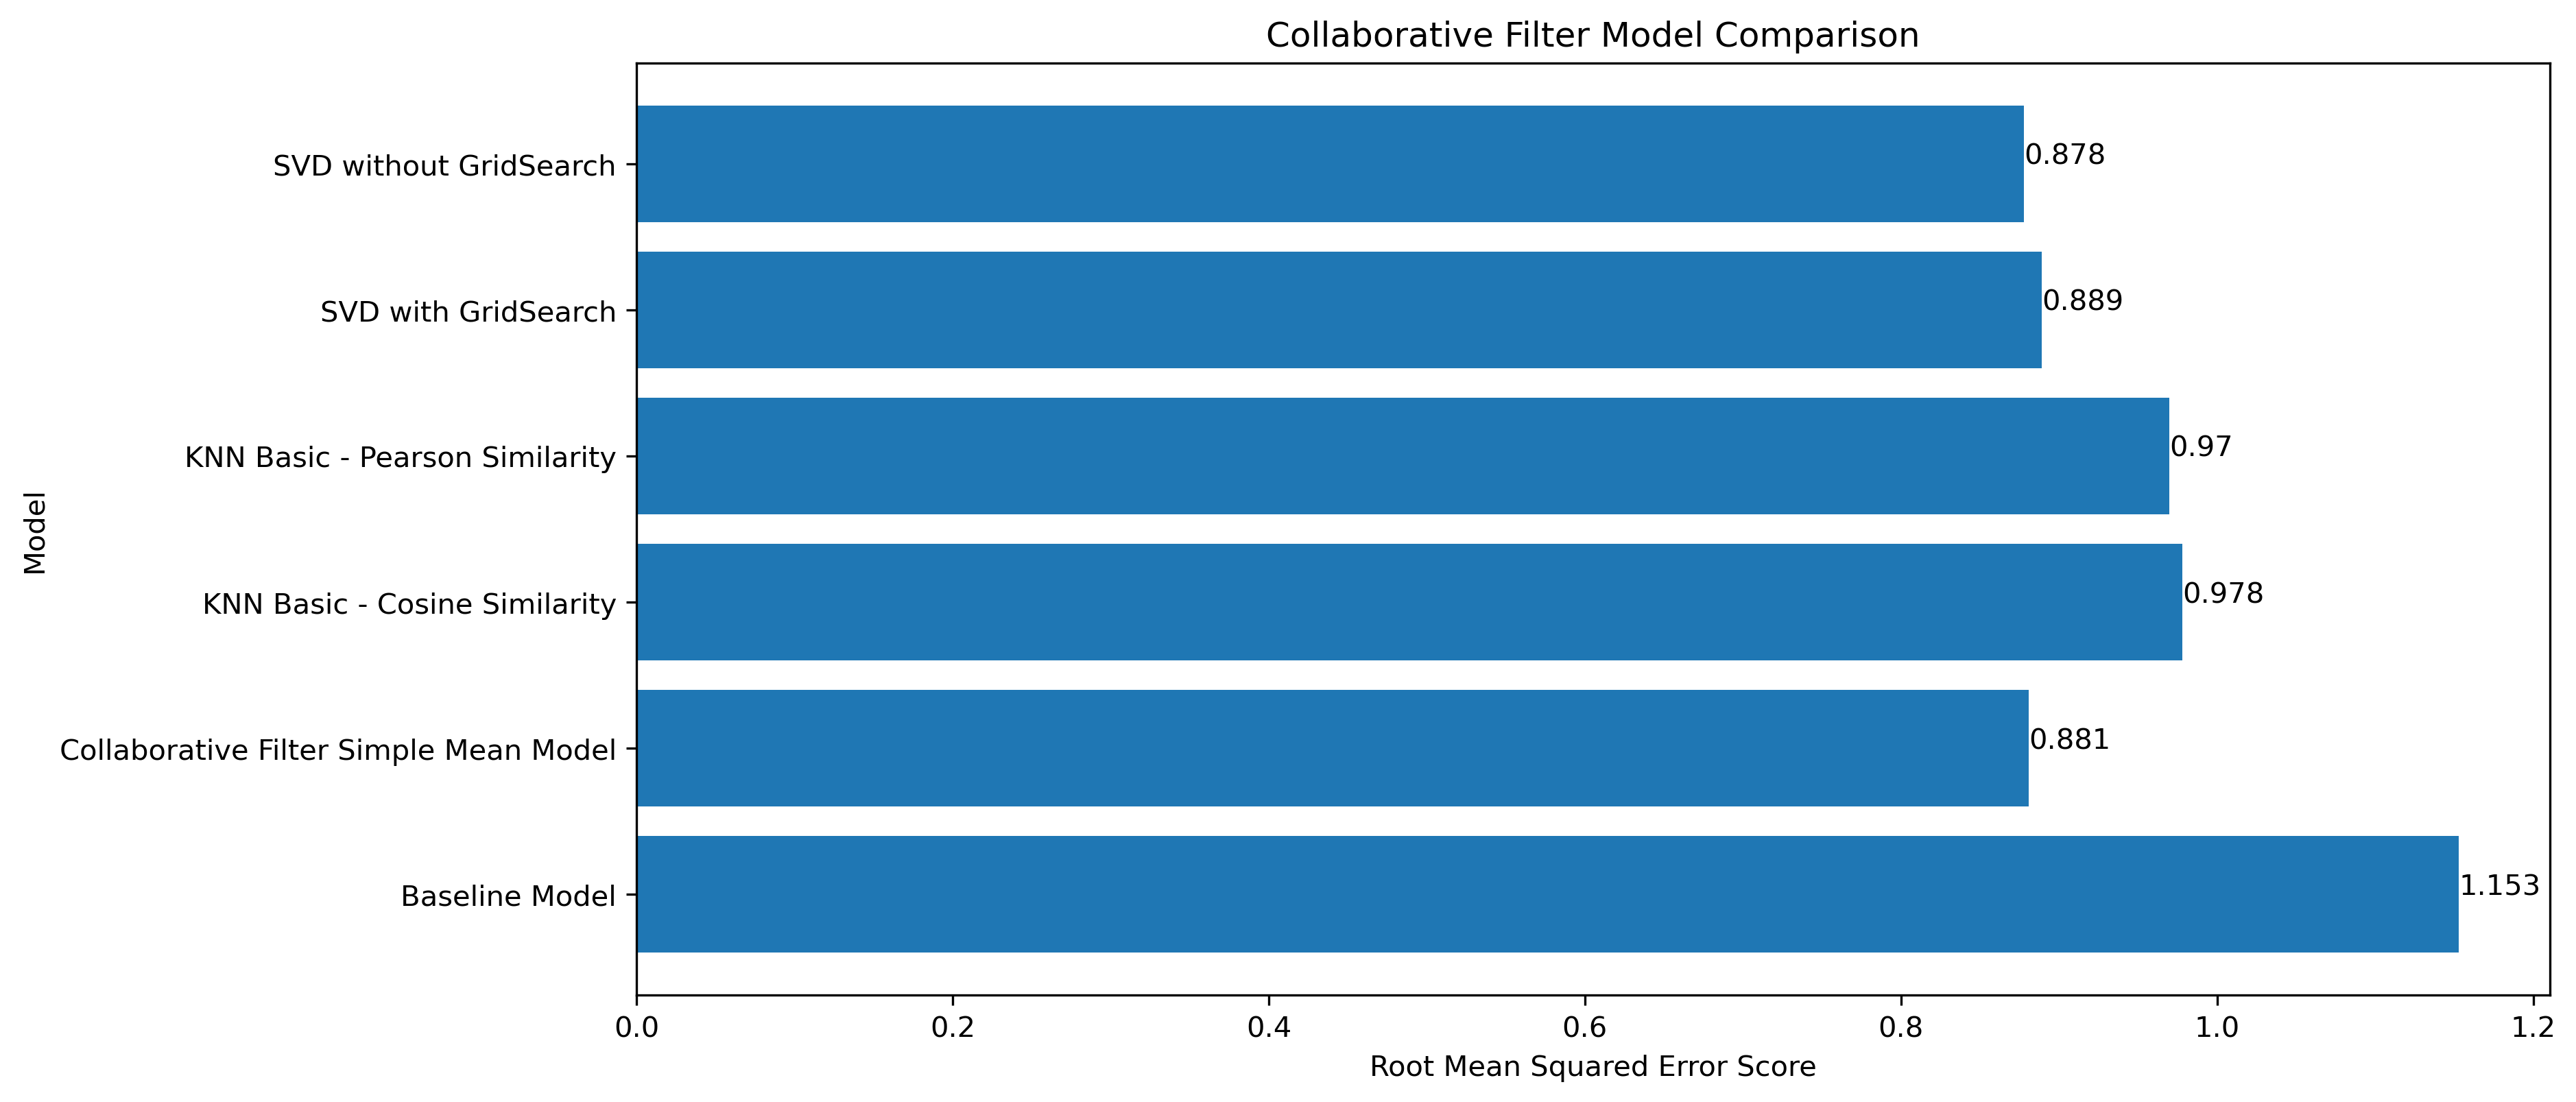

In [79]:
# Plot results
plt.figure(figsize=(12,6),dpi=300)

test_rmse_scores = list(modelAgg_testRMSE.test_rmse)
x_labels = list(modelAgg_testRMSE.model)

plt.barh(x_labels,test_rmse_scores)
plt.ylabel('Model')
plt.xlabel('Root Mean Squared Error Score')
plt.title('Collaborative Filter Model Comparison')

for index, value in enumerate(test_rmse_scores):
    plt.text(value, index, str(value))
    
# Savefig
plt.savefig('CollaborativeFilterModelComparison.jpg',dpi=300, bbox_inches = 'tight')

The visual above showcases the mean RMSE score (through 5 cross-validation folds of the user-rating data) per collaborative filter model. Based on the results, the SVD without gridsearch parameter tuning CF model performed best with a mean RMSE score of 0.878. For our hybrid model, we will move forward with the SVD without GridSearch model.

# Content Based Filter
In this section we will aim to address the **cold-start problem** in which our recommender does not contain past data or information of what a user has rated before, and hence no information about a user's taste or preferences for movies.

With a content based filter (similar to Netflix), a user is asked to input / mark movies they do like, and return the most similar results. By most similar results, we can create a content based filter model using the provided metadata from GroupLens

2. Metadata-based recommender
- Compare genres, and taglines

- Create single document vectors per movie based on title, tags, and genres
- Compute similarity scores
- Build metadata recommender function

In [45]:
# Create genres_tags_df to collect the genres and tags for our content based filter model
genres_tags_df = pd.merge( movies_df, ratings_df, how='left', on='movieId' )

# Remove unneeded column
genres_tags_df.drop(['timestamp','userId','rating'],axis=1,inplace=True)

# Drop duplicates
genres_tags_df.drop_duplicates(inplace=True)

# Peek data
genres_tags_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
215,2,Jumanji (1995),Adventure|Children|Fantasy
325,3,Grumpier Old Men (1995),Comedy|Romance
377,4,Waiting to Exhale (1995),Comedy|Drama|Romance
384,5,Father of the Bride Part II (1995),Comedy


In [46]:
# Group tags to join to genres_tags_df 
grouped_tags = pd.DataFrame(tags_df.groupby('movieId').apply(lambda x: ','.join(x.tag)))
grouped_tags.reset_index(inplace=True)
grouped_tags.rename(columns={0:'tags'},inplace=True)
grouped_tags.head()

,movieId,tags
0,1,"pixar,pixar,fun"
1,2,"fantasy,magic board game,Robin Williams,game"
2,3,"moldy,old"
3,5,"pregnancy,remake"
4,7,remake


In [47]:
# Combine the tags to genres
genres_tags_df = pd.merge( genres_tags_df, grouped_tags, on='movieId',how='inner' )
genres_tags_df.head()

,movieId,title,genres,tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"pixar,pixar,fun"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"fantasy,magic board game,Robin Williams,game"
2,3,Grumpier Old Men (1995),Comedy|Romance,"moldy,old"
3,5,Father of the Bride Part II (1995),Comedy,"pregnancy,remake"
4,7,Sabrina (1995),Comedy|Romance,remake


In [48]:
genres_tags_df.title.map(lambda x: x.split(' ('))

0                         [Toy Story, 1995)]
1                           [Jumanji, 1995)]
2                  [Grumpier Old Men, 1995)]
3       [Father of the Bride Part II, 1995)]
4                           [Sabrina, 1995)]
                        ...                 
1567                     [Game Night, 2018)]
1568                    [Tomb Raider, 2018)]
1569                     [Deadpool 2, 2018)]
1570        [Solo: A Star Wars Story, 2018)]
1571             [Gintama: The Movie, 2010)]
Name: title, Length: 1572, dtype: object

In [49]:
# Remove the year from the title string
genres_tags_df['title'] = genres_tags_df['title'].map(lambda x: x.split(' (')[0])

# Clean genres and tags column and create new document column
genres_tags_df['genres'] = genres_tags_df['genres'].map(lambda x: x.replace('|',' '))

genres_tags_df['tags'] = genres_tags_df['tags'].map(lambda x: x.replace(',',' '))

genres_tags_df['movie_document'] = genres_tags_df['genres']+' '+genres_tags_df['tags']

genres_tags_df.head()

,movieId,title,genres,tags,movie_document
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,pixar pixar fun,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji,Adventure Children Fantasy,fantasy magic board game Robin Williams game,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men,Comedy Romance,moldy old,Comedy Romance moldy old
3,5,Father of the Bride Part II,Comedy,pregnancy remake,Comedy pregnancy remake
4,7,Sabrina,Comedy Romance,remake,Comedy Romance remake


In [50]:
# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer()

# Create tfidf matrix from newly created movie_document column
tfidf_matrix = tfidf.fit_transform(genres_tags_df['movie_document'])

# Check out shapre of matrix
tfidf_matrix.shape

(1572, 1748)

In [51]:
# Compute the cosine similarity matrix using linear_kernel
movie_cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [52]:
# Create mapping of indices to titles for sorting of movie cosine sim given a movie title
indices = pd.Series(genres_tags_df.index, index=genres_tags_df['title']).drop_duplicates()

In [53]:
def content_rec_model(movie_title, movie_cosine_sim=movie_cosine_sim, genres_tags_df=genres_tags_df, indices=indices):
    # Obtain the index of the movie that matches the movie_title
    idx = indices[movie_title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(movie_cosine_sim[idx]))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. Ignore the first movie.
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return genres_tags_df['title'].iloc[movie_indices]

In [54]:
# Get top 10 content based recommendations from a given title -- 'Toy Story'
content_rec_model('Toy Story')

544                        Bug's Life, A
666                          Toy Story 2
1427                                  Up
1444                              Sintel
1524           Guardians of the Galaxy 2
1281                    Cat Returns, The
1274             Kiki's Delivery Service
248                  Alice in Wonderland
1033    Sinbad: Legend of the Seven Seas
643             Who Framed Roger Rabbit?
Name: title, dtype: object

Given an input of the *Toy Story* movie, we are able to observe that 6 out of 10 of the most similar movies are in fact Disney movies. The top 3 movies found most similar to *Toy Story* are also found to be a part of Pixar studios. If a user is watching or have watched *Toy Story*, they may have a penchant for animated movies or Disney movies in general. For either reason, the our content based model may not accurately capture those preferences.

In our hybrid model, we will aim to incorporate movies our user have rated in the past to tune the recommendations and deliver a clear line between a preference for Disney movies, animated movies, or something else.

# Hybrid Model
In this approach, we will use both out content based filtering model, as well as our collaborative filter model to
1. Take in a movie title, and a user id as input
2. Use the content based filter to output X top movies, similar to the movie title
3. Use the collaborative filter model to predict the ratings the given user may rate the top X movies

In [55]:
# Instantiate reader to reader load data into surprise API
reader = Reader()

# Load previously preapred movieRatings_df to read as surprise dataframe object
ratings_data = Dataset.load_from_df(movieRatings_df, reader)

# Create training set from ratings_data
movie_trainset = ratings_data.build_full_trainset()

In [56]:
# Use svd model and params determined during grid search exercise
svd_hybrid = SVD(n_factors=20, n_epochs=10, lr_all=0.005, reg_all=0.4)

# Fit on ratings data defined above
svd_hybrid.fit(movie_trainset)

In [80]:
def hybrid_model(userid, movie_title, top_n):
    # Use indices movie title mapping
    idx = indices[movie_title]
    
    # Retrieve movieId using movie_title
    movieid = genres_tags_df[genres_tags_df['title']==movie_title]['movieId'].item()
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(movie_cosine_sim[idx]))
    
    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top_n most similar movies
    sim_scores = sim_scores[1:top_n+1]
    
    # Store the cosine_sim indices of the top_n movies in a list
    movie_indices = [i[0] for i in sim_scores]

    # Filter for top_n movies most similar (defined by movie_indices)
    movies_rec = genres_tags_df.iloc[movie_indices]
    
    # Get predicted ratings, access predicted rating at index 3
    movies_rec['predict'] = movies_rec['movieId'].map(lambda x: svd_hybrid.predict(x, userid)[3])
    
    # Sort movies in descending order according to predicted rating value
    movies_rec = movies_rec.sort_values('predict', ascending=False)
    
    # Return the top 10 movie recs
    return movies_rec[['title','predict']].head(10)

In [115]:
hybrid_model(1,'Toy Story',30)

,title,predict
922,Spirited Away,4.569530
1427,Up,4.467934
1011,Laputa: Castle in the Sky,4.464766
613,"Iron Giant, The",4.434395
947,My Neighbor Totoro,4.412023
812,Shrek,4.379998
666,Toy Story 2,4.358061
1274,Kiki's Delivery Service,4.352397
1524,Guardians of the Galaxy 2,4.325302
1497,The Lego Movie,4.320881


In [114]:
hybrid_model(448,'Toy Story',30)

,title,predict
922,Spirited Away,3.116303
1427,Up,3.015371
1011,Laputa: Castle in the Sky,3.012288
613,"Iron Giant, The",2.982639
947,My Neighbor Totoro,2.960604
812,Shrek,2.927080
666,Toy Story 2,2.905760
1274,Kiki's Delivery Service,2.905352
1524,Guardians of the Galaxy 2,2.881467
1497,The Lego Movie,2.871004


Based on the predicted ratings between user ID 1 and user ID 488 -- it is apparent that user 1 has a higher preference for the movies found similar to *Toy Story* compared to user 448. For the top 10 movies most similar to *Toy Story*, user 1 rated the movies with an average 1.5 higher than user 448.

In the case for user 1, they may be watching *Toy Story* and given their higher ratings for similar movies, the content based model may be appropriate to serve a new movie recommendation. On the other hand, for user 448, while they did watch *Toy Story*, they rated the other similar movies lower. One could assume in addition to *Toy Story*, user 448 may have other genres they are interested in, therefore we may want to rely on collaborative filtering to identify similar users and recommend movies they like, and user 448 have not watched. Between both users, we are able to employ content and collaborative filter models to serve a recommendation.